# Simulating from the contagion model
## Load packages and data

In [42]:
library(ggplot2)
library(qgraph)

The ```attributes.csv``` dataset has information on each of 117 doctors. But for this project, the only column we are interested in is the ```adoption_date```, which indicates the month in which the doctor first prescribed the new medicine, Tetracycline.

In [43]:
attr_url <- "https://raw.githubusercontent.com/andrewdk1123/abc-network/main/attributes.csv"
attributes <- read.csv(attr_url)

head(attributes)

,city,adoption_date,med_sch_yr,meetings,jours,free_time,discuss,clubs,friends,community,patients,proximity,specialty
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,2,2,8,1,1,0,1,6,5,3,3
2,1,12,6,0,4,3,2,0,4,1,4,3,1
3,1,8,4,1,6,3,1,0,3,5,4,2,2
4,1,9,5,1,5,1,1,0,1,4,3,3,1
5,1,9,4,1,3,1,2,0,2,5,3,2,1
6,1,10,3,0,6,2,2,0,1,5,5,3,2


In the cell below, the ```init_adopt``` contains pieces of information about doctors who have adopted the Tetracycline at the beggining of the study. We see that there are 5 doctors who firstly prescribed the medicine.

In [44]:
init_adopt = attributes[attributes$adoption_date == 1,]
print(init_adopt)

   city adoption_date med_sch_yr meetings jours free_time discuss clubs friends
1     1             1          2        2     8         1       1     0       1
27    1             1          4        2     4         2       2     1       2
75    1             1          3        0     1         1       1     0       1
78    1             1          3        2     7         3       1     0       2
93    1             1          2        2     8         1       1     0       1
   community patients proximity specialty
1          6        5         3         3
27         5        4         3         3
75         5        5         9         1
78         5        3         2         3
93         6        2         1         2


Another data file, ```network.csv```, is a matrix describing a directed network: element (i, j) is 1 if doctor i listed doctor j as someone he discussed patients with.

In [45]:
net_url <- "https://raw.githubusercontent.com/andrewdk1123/abc-network/main/network.csv"
network <- read.csv(net_url)

head(network); dim(network)

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 117 117

Using the matrix, we can describe the interconnection between doctors. In the plot below, each node is representing a doctor, and each arrow is representing with whom the doctor discussed about prescriptions. After discussions, doctors prescribe the new medicine with the probability of $p$.

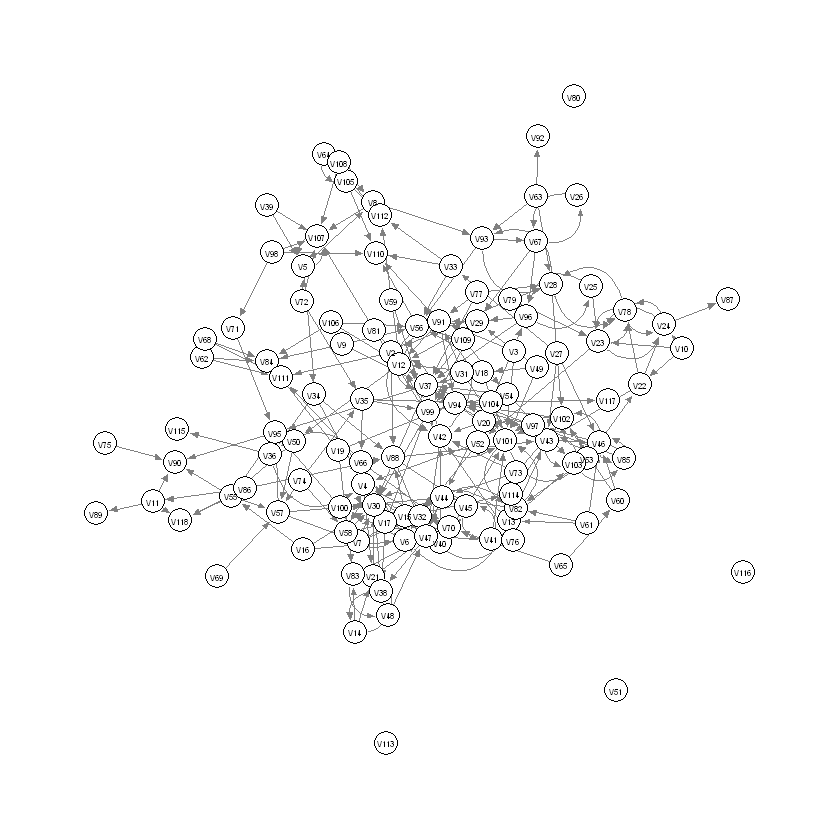

In [46]:
rownames(network) = colnames(network)
qgraph(network)

The ```sim_model``` function simulates an SI contagion model. In this model, nodes can be in one of two states: _susceptible_ or _infected_. Initially, some nodes are _infected_ as we saw there are 5 doctors who initially used Tetracycline. Each node that is connected to an infected node has a probability of $p$ to become infected. For each step, the infected nodes can infect their connected susceptible nodes.

The function takes four arguments:

 - network: A network object that represents the interactions between nodes.
 - init_nodes: A vector of the nodes that initially adopt the technology.
 - p_adopt: The probability that a node will adopt the technology if it is influenced by a neighbor who has already adopted.
 - n_step: The number of steps to simulate.

The function works by first setting the initial adopters. This is done by setting the ```adopt_time``` attribute of the corresponding nodes to 1. The function then loops through the steps. In each step, the function does the following:

 1. Gets the nodes that have already adopted.
 2. For each node that has adopted, gets the nodes that it interacts with.
 3. For each node that interacts with an adopted node, checks to see if the node has already adopted (infected). If the node has not already adopted (susceptible), the function checks to see if the node will adopt. If the node will adopt, the function sets the ```adopt_time``` attribute of the node to the current step.

In [47]:
sim_model <- function(network, init_nodes, p_adopt, n_step){
    
    sim_attr = data.frame(doctor = as.integer(rownames(attributes)), adopt_time = NA)
  
    # Set the initial adoptors in the data
    init_nodes = as.integer(rownames(init_adopt))
    sim_attr[init_nodes,]$adopt_time = 1
  
    for (i in 2:n_step){
        
        # Get the row number of the adopted nodes
        adopted_nodes = rownames(sim_attr[!is.na(sim_attr$adopt_time),])
        adopted_nodes = as.integer(adopted_nodes)
    
        # Loop through the nodes which have adopted
        for (j in adopted_nodes){
            current_doc = sim_attr[j,]$doctor
      
            # Get the nodes the starting node interacts with
            neighbors = get_neighbors(current_doc, network, sim_attr)
      
            # Drop any possible NA values
            neighbors = neighbors[!is.na(neighbors$doctor),]
      
            if (nrow(neighbors) > 0){
                # Select a neighbor
                samples = neighbors$doctor
                neighbor_idx = sample(samples, 1)
        
                neighbor = neighbors[neighbors$doctor == neighbor_idx,]
        
                # Check to see if the neighbor has already adopted
                neighbor_adopt_date = neighbor$adopt_time
        
                if (is.na(neighbor_adopt_date) || neighbor_adopt_date > n_step){
                # Check to see if the doctor will adopt
                    adopted = rbinom(n = 1, size = 1, prob = p_adopt)
          
                    if (adopted == 1){
                        sim_attr[sim_attr$doctor == neighbor$doctor,]$adopt_time = i
                    }
                }
            }
        }
    }
  
    return(sim_attr)
}

The ```get_neighbors``` function takes three arguments:

 - starting_node: The node whose neighbors we want to find.
 - network: A network matrix that represents the interactions between nodes.
 - sim_attr: The time records when doctors adopted the new medicine.
 
The function works by first getting the nodes that the starting node interacts with. This is done by taking the row of the network object corresponding to the starting node and selecting all the columns where the value is 1. The names of these columns are then extracted and converted to integers. These integers are then used to index into the ```sim_attr``` matrix to take the adoption time. This matrix can be expanded to calculate the similarity scores between all pairs of nodes in a more complex model. However, in this project, we are only interested in the adoption time only.

In [48]:
get_neighbors <- function(starting_node, network, sim_attr){
    # Get the nodes the starting node interacts with
    neighbor_net = network[starting_node, network[starting_node,] == 1]
    neighbor_cols = colnames(neighbor_net)
    neighbor_idx = as.integer(substring(neighbor_cols, 2))
  
    neighbors = sim_attr[neighbor_idx,]
  
    return(neighbors)
}

The function then returns a data frame that contains the following information for each node:

 - ```doctor```: The ID of the node.
 - ```adopt_time```: The step at which the node adopted the medicine.


We can simulate from the model given the real data parameters for the doctor discussion network, the initially infected nodes (the doctors who prescribed Tetracycline in month 1), and the number of time steps (18 months). 

In the cell below, I did one simulation each for $p = .1, .5, .9$. It shows what one realization of the simulation looks like.

In [55]:
prob1 <- sim_model(network, init_adopt, 0.1, 18)
prob5 <- sim_model(network, init_adopt, 0.5, 18)
prob9 <- sim_model(network, init_adopt, 0.9, 18)

sim_result <- cbind(prob1, prob5, prob9)
sim_result <- sim_result[,c(1, 2, 4, 6)]
names(sim_result) <- c("Doctors", "Adopted Month (p = 0.1)", "Adopted Month (p = 0.5)", "Adopted Month (p = 0.9)")
sim_result

Doctors,Adopted Month (p = 0.1),Adopted Month (p = 0.5),Adopted Month (p = 0.9)
<int>,<dbl>,<dbl>,<dbl>
1,1,1,1
2,NA,15,14
3,NA,NA,NA
4,NA,11,9
5,NA,NA,7
6,NA,NA,4
7,NA,11,13
8,NA,14,12
9,NA,NA,NA


# Approximate Bayesian Computation

One remaining question here is how to determine the unknown parameter $p$. In the simulation above, I arbitrarily assigned the values 0.1, 0.5, and 0.9 for $p$, but this is not a satisfactory solution.

One possible approach is to use _**Approximate Bayesian Computation**_. The Approximate Bayesian Computation (ABC) is a computational method used in Bayesian inference when the likelihood function of the model is unknown or difficult to calculate. Instead of calculating the exact posterior distribution, ABC methods seek to simulate samples from the posterior distribution by comparing the observed data to simulated data generated from the model.

The general idea of ABC is to simulate a large number of parameter sets from the prior distribution and simulate data from the model for each set of parameters. The simulated data is then compared to the observed data using a distance function that measures how well the simulated data matches the observed data. If the distance is smaller than a specified threshold, the parameter set is retained, otherwise it is discarded. The retained parameter sets are used to approximate the posterior distribution.

While it can be computationally expensive, ABC can be used in a wide range of applications, including population genetics, epidemiology, and social science. It has proven particularly useful in cases where traditional methods of Bayesian inference are not applicable due to the complexity of the model or the intractability of the likelihood function.

In this project, using a uniform prior over $p$, the transmission probability, I applied ABC to get samples from the approximate posterior distribution of $p$ given the observed data. The ```abc_sim``` function below simulates the spread of the new prescription through a social network between doctors, and then uses ABC algorithm to estimate the probability that a node will adopt the medicine. The function takes two arguments:

 - n_sims: The number of simulations to run.
 - epsilon: The acceptance rate.

The function works by first running n_sims simulations of the spread of the Tetracycline. For each simulation, the function generates a random probability that a node will adopt the technology. The function then calculates the mean adoption time for the nodes that adopt the technology. After that, the function compares the mean adoption time for each simulation to the mean adoption time for the observed data. 

If a simulation have a mean adoption time within epsilon distance of the observed mean adoption time, then the function accepts the simulation. For this, I also created another function named ```calc_distance``` below. Finally, the function returns the accepted probabilities.

In [56]:
abc_sim <- function(n_sims, epsilon){
    obs_times = attributes[attributes$adoption_date <= 18,]$adoption_date
    obs_mean = mean(obs_times)
  
    probs = runif(n_sims, min = 0, max = 1)
    mean_diffs = rep(NA, n_sims)
  
    accept_number = epsilon * n_sims
  
    for (i in 1:length(probs)){
        prob = probs[i]
    
        new_data <- sim_model(network, init_adopt, prob, 18)
        adopt_times <- na.omit(new_data$adopt_time)
    
        mean_diffs[i] <- abs(mean(adopt_times) - obs_mean)
    }
  
    ordered_diffs <- mean_diffs[order(mean_diffs)]
    accepted_probs <- probs[c(1:accept_number)]
    print(accepted_probs)
}

In [57]:
calc_distance <- function(sim_data, obs_data)
{
  norm <- sqrt(sum(abs(obs_data - sim_data) ^ 2))
  
  distance <- 0.5 * norm
  
  return(distance)
}

In [62]:
accepted = abc_sim(3000, 0.05)
accepted

  [1] 0.796032869 0.526802115 0.601194102 0.952121915 0.137364041 0.803085288
  [7] 0.464936638 0.763358789 0.937223808 0.122194444 0.152858784 0.611976908
 [13] 0.755115304 0.484562600 0.959596307 0.683356590 0.292674320 0.618600910
 [19] 0.502852682 0.296540700 0.353501816 0.988980703 0.524657148 0.317513331
 [25] 0.893753812 0.135618903 0.950501734 0.339790208 0.673600957 0.111467048
 [31] 0.822383754 0.188119065 0.105235656 0.632407344 0.829227848 0.173362262
 [37] 0.599129166 0.626740461 0.874410728 0.612232475 0.219326884 0.556160961
 [43] 0.545514812 0.003947697 0.117922235 0.112479828 0.556092308 0.509449003
 [49] 0.950492645 0.120220756 0.153364984 0.468257228 0.807664968 0.847600556
 [55] 0.669088072 0.210441801 0.262615441 0.713250605 0.339232272 0.423801999
 [61] 0.770005434 0.533136033 0.225842220 0.101986715 0.705167245 0.482681953
 [67] 0.226283336 0.805955714 0.640842927 0.095688626 0.765554245 0.600713455
 [73] 0.507903218 0.575379120 0.582576082 0.893610832 0.51805934

[1] 0.796032869 0.526802115 0.601194102 0.952121915 0.137364041 0.803085288
  [7] 0.464936638 0.763358789 0.937223808 0.122194444 0.152858784 0.611976908
 [13] 0.755115304 0.484562600 0.959596307 0.683356590 0.292674320 0.618600910
 [19] 0.502852682 0.296540700 0.353501816 0.988980703 0.524657148 0.317513331
 [25] 0.893753812 0.135618903 0.950501734 0.339790208 0.673600957 0.111467048
 [31] 0.822383754 0.188119065 0.105235656 0.632407344 0.829227848 0.173362262
 [37] 0.599129166 0.626740461 0.874410728 0.612232475 0.219326884 0.556160961
 [43] 0.545514812 0.003947697 0.117922235 0.112479828 0.556092308 0.509449003
 [49] 0.950492645 0.120220756 0.153364984 0.468257228 0.807664968 0.847600556
 [55] 0.669088072 0.210441801 0.262615441 0.713250605 0.339232272 0.423801999
 [61] 0.770005434 0.533136033 0.225842220 0.101986715 0.705167245 0.482681953
 [67] 0.226283336 0.805955714 0.640842927 0.095688626 0.765554245 0.600713455
 [73] 0.507903218 0.575379120 0.582576082 0.893610832 0.518059342 0.843844194
 [79] 0.774708066 0.246027037 0.062591734 0.952247927 0.933782975 0.700406610
 [85] 0.886140183 0.803980640 0.899275598 0.259274893 0.403333467 0.993624591
 [91] 0.296428087 0.966966268 0.691557380 0.981864640 0.707897145 0.244451963
 [97] 0.396415767 0.989311209 0.830369673 0.884216975 0.688915076 0.741501335
[103] 0.656795041 0.356159033 0.832741569 0.524924261 0.621157079 0.325355028
[109] 0.112777673 0.139919014 0.523596487 0.887610309 0.810692399 0.019578222
[115] 0.363877524 0.561513452 0.122612377 0.217084452 0.286219895 0.681360476
[121] 0.250754464 0.610806142 0.026264969 0.653524877 0.773662941 0.656264004
[127] 0.181647714 0.211323680 0.054838383 0.529736422 0.010992616 0.304177629
[133] 0.819661608 0.121823175 0.111802962 0.671232803 0.793660988 0.410531747
[139] 0.585250496 0.993335981 0.840810513 0.275151367 0.885900721 0.349724697
[145] 0.777086436 0.708863748 0.102755266 0.834862459 0.658552380 0.742602409

Above is the accepted approximations of the transmission probability.

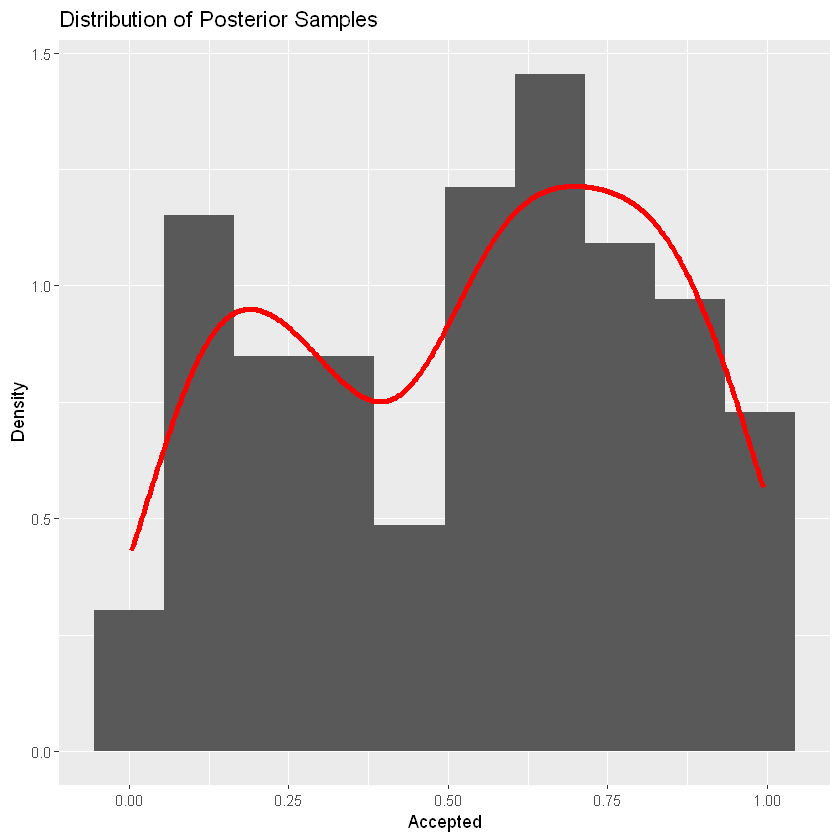

In [70]:
plot_data <- data.frame(accepted = accepted)

ggplot(data = plot_data, aes(x = accepted)) +
  geom_histogram(aes(y = ..density..), bins = 10) +
  geom_density(linewidth = 1.5, color = "red") +
  labs(title = "Distribution of Posterior Samples", x = "Accepted", y = "Density")

In [71]:
summary(plot_data$accepted)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003948 0.265749 0.578978 0.533361 0.776492 0.993625 